In [1]:
import json
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import savgol_filter

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'

In [3]:
def loadingDataReader(fileAddress,parameter):
    try:
        jsonFile = open(fileAddress, )
        data = json.load(jsonFile)

        dateList=[]
        timeList=[]
        valList=[]
        for i in data:
            for j in data[i]:
                timeTemp=j["time"]
                timeTemp=int(timeTemp[0:2])*3600+int(timeTemp[3:5])*60+int(timeTemp[6:8])
                timeList.append(timeTemp)

                dateTemp=i
                dateTemp = datetime.strptime(dateTemp, '%m-%d')+relativedelta(years=+121)
                dateTemp=dateTemp.timetuple().tm_yday
                dateList.append(dateTemp)
                valList.append(float(j["value"]))
        jsonFile.close()
    except:
        print("An exception occurred")

    parList = []
    for i in range (0,len(dateList)):
        parList.append(parameter)

    return dateList,timeList,valList,parList

def loadingDataAux(fileAddress,parameter,allDate,allTime,allVal,allPar):
    fileAddress=os.path.normpath(fileAddress)
    [tempDate,tempTime,tempVal,tempPar]=loadingDataReader(fileAddress,parameter)
    allDate.extend(tempDate)
    allTime.extend(tempTime)
    allVal.extend(tempVal)
    allPar.extend(tempPar)
    print(parameter," is done")

    return allDate,allTime,allVal,allPar

def dataGapChecker(df):
    gapLength=1
    df=df.sort_values(by=['Parameter', 'Date','Time'])
    gapList=[]

    highResSensor=['Acc','EDA','HR','Temp','CGM']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter+1,0]:
                if newQuery.iloc[counter+1,1]-newQuery.iloc[counter,1]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter+1,1],newQuery.iloc[counter,3]])
    appendedData=[]
    for element in gapList:
        duration= element[2]-element[1]
        for counter in range(0,int(duration/gapLength)):
            appendedData.append([element[0],element[1]+(counter+1)*gapLength,float('nan'),element[3]])

    df = df.append(pd.DataFrame(appendedData,columns=['Date','Time','Value','Parameter']),ignore_index = True)
    df=df.sort_values(by=['Parameter','Date','Time'])
    return df

def dataCleaner(df):
    i = df[((df.Parameter == 'Temp') &( df.Value < 20))].index
    df=df.drop(i)

    i = df[df.Date == 30].index #first data and noisy
    df=df.drop(i)

    i = df[df.Date == 40].index #Partial E4
    df=df.drop(i)

    i = df[df.Date == 41].index #No E4
    df=df.drop(i)

    i = df[df.Date >= 42].index #CGM becomes too noisy at the end of the study
    df=df.drop(i)

    df=df.interpolate(method='linear')
    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        dfOriginal = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),
                          columns =['Date','Time','Value','Parameter'])
        dfOriginal=dfOriginal.sort_values(by=['Parameter','Date','Time'])
        dfOriginal.to_csv(addressPrefix+'Result-original.csv', header=True,index=False)
        dfInterp=dataGapChecker(dfOriginal)
        dfInterp=dataCleaner(dfInterp)
        dfInterp.to_csv(addressPrefix+'Result-interpolated.csv', header=True,index=False)
    else:
        dfOriginal=pd.read_csv(addressPrefix+'Result-original.csv')
        dfInterp=pd.read_csv(addressPrefix+'Result-interpolated.csv')
    return dfOriginal,dfInterp

dfOriginal,dfInterp=loadingData(addressPrefix)

Acc  is done
Cal  is done
EDA  is done
HR  is done
Step  is done
Temp  is done
CGM  is done


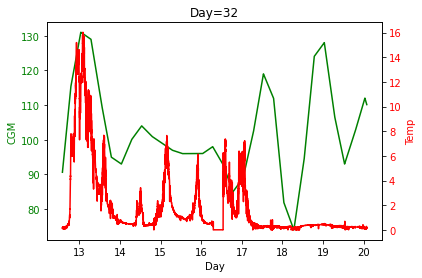

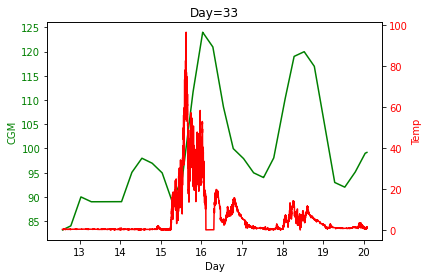

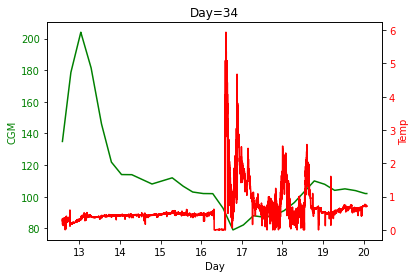

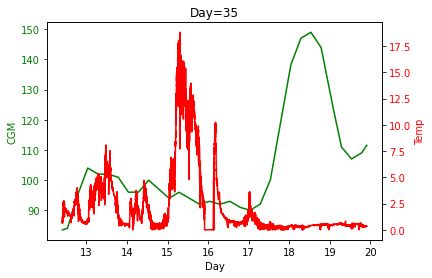

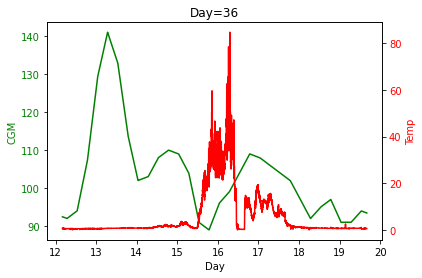

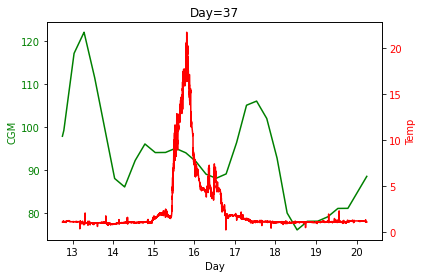

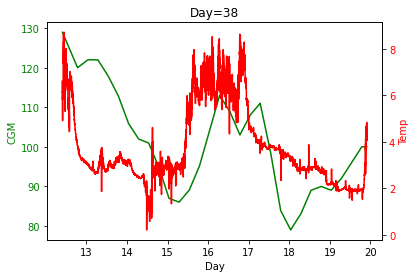

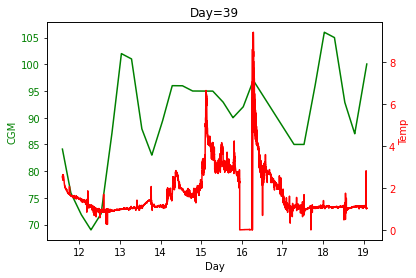

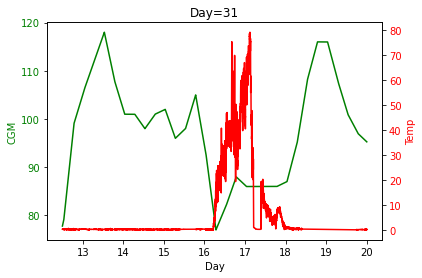

[ 0.         32.          0.43546499  0.        ]
[ 0.         33.          0.34596523  0.        ]
[ 0.         34.         -0.37570971  0.        ]
[ 0.         35.         -0.30812439  0.        ]
[ 0.00000000e+000  3.60000000e+001 -1.98631874e-001  2.49336812e-238]
[ 0.00000000e+00  3.70000000e+01 -1.90497222e-03  7.54277115e-01]
[ 0.         38.          0.30728115  0.        ]
[0.00000000e+000 3.90000000e+001 1.51036851e-001 1.66123313e-137]
[ 0.         31.         -0.49099749  0.        ]
----------------------
-0.015068912875401297
----------------------


In [13]:
windowDuration=8*3600
lagTimes=np.arange(-1*3600,2*3600,0.5*3600)
lagTimes=[0]
mealTimes=[12.33*3600,12.33*3600,12.33*3600,12.16*3600,11.92*3600,
           12.5*3600,12.16*3600,11.33*3600,12.25*3600]

# mealTime=0*3600
# windowDuration=24*3600
# lagTime=0*3600
pearsons=[]
plotFlag=True
days=dfInterp['Date']
days=days.values.tolist()
days=set(days)
days=list(days)
for lagTime in lagTimes:
    for counter,day in enumerate(days):
        mealTime=mealTimes[counter]

        inqueryCGM=dfInterp[dfInterp['Date']==day]
        inqueryCGM=inqueryCGM[inqueryCGM['Parameter']=='CGM']
        inqueryCGM=inqueryCGM[inqueryCGM['Time']<=mealTime+windowDuration]
        inqueryCGM=inqueryCGM[inqueryCGM['Time']>=mealTime]

        x=inqueryCGM['Time']
        x=x.values.tolist()
        x=np.asarray(x,dtype=float)
        y=inqueryCGM['Value']
        y=y.values.tolist()
        y=np.asarray(y,dtype=float)
        f = interp1d (x, y,fill_value="extrapolate")
        xNewCGM=np.arange(mealTime+0.25*3600,mealTime+windowDuration-0.25*3600,1)
        CGMNew=f(xNewCGM)

        inqueryVar=dfInterp[dfInterp['Date']==day]
        inqueryVar=inqueryVar[inqueryVar['Parameter']=='EDA']
        inqueryVar=inqueryVar[inqueryVar['Time']<=mealTime+windowDuration+lagTime]
        inqueryVar=inqueryVar[inqueryVar['Time']>=mealTime+lagTime]

        x=inqueryVar['Time']
        x=x.values.tolist()
        x=np.asarray(x,dtype=float)

        y=inqueryVar['Value']
        y=y.values.tolist()
        y=np.asarray(y,dtype=float)
        f = interp1d (x, y,bounds_error=False, fill_value=0)
        xNewVar=np.arange(mealTime+lagTime+0.25*3600,mealTime+lagTime+windowDuration-0.25*3600,1)
        varNew=f(xNewVar)

        # properVar=np.logical_not(np.isnan(varNew))
        # properCGM=np.logical_not(np.isnan(CGMNew))
        # properIndices=properVar*properCGM
        #
        # xNew=xNew[np.argwhere(properIndices)]
        # varNew=varNew[np.argwhere(properIndices)]
        # CGMNew=CGMNew[np.argwhere(properIndices)]
        #
        # varNew=np.concatenate(varNew, axis=0)
        # CGMNew=np.concatenate(CGMNew, axis=0)
        if plotFlag:
            fig, ax1 = plt.subplots ()
            ax2 = ax1.twinx ()
            ax1.plot(xNewCGM/3600,CGMNew,color='green')
            ax1.tick_params (axis='y', labelcolor='green')

            ax2.plot(xNewVar/3600,varNew,color='red')
            ax2.tick_params (axis='y', labelcolor='red')

            ax1.set_ylabel('CGM')
            ax1.set_xlabel('Day')
            ax1.yaxis.label.set_color("green")

            ax2.set_ylabel('Temp')
            ax2.yaxis.label.set_color("red")

            plt.savefig(addressPrefix+'figure'+str(day)+'.jpg')
            plt.title("Day="+str(day))
            plt.show()

        corr, pval = pearsonr(CGMNew, varNew)
        # print("Pearson ratio=", corr, "p-val=",pval)
        pearsons.append([lagTime,day,corr, pval])
pearsons=np.asarray(pearsons)
for i,lagTime in enumerate(lagTimes):
    for j,day in enumerate(days):
        print(pearsons[i*9+j])
    print("----------------------")
    print(np.mean(pearsons[i*9:i*9+9,2]))
    print("----------------------")